In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install pydub

In [4]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, LSTM)
from keras.models import Model, load_model
from PIL import Image
import numpy as np
from pydub import AudioSegment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [5]:
genres_musicaux = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [6]:
def get_features():
  labels = []
  features = []
  i = 0
  for g in genres_musicaux:
    print(g)
    for filename in os.listdir(os.path.join('/content/gdrive/MyDrive/Projet Majeure/Premier test/audio3sec/',f'{g}')):
      if not filename.startswith('.'):    #avoiding the .DS_Store file
        path = os.path.join('/content/gdrive/MyDrive/Projet Majeure/Premier test/audio3sec/',f'{g}',f'{filename}')
        y,sr = librosa.load(path,duration=3)
        mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20))

        if len(mfcc[1]) != 259 :      #avoiding some problem of array length
          diff = 259-len(mfcc[1])
          zeros = np.zeros((20,diff))
          mfcc = np.concatenate((mfcc,zeros),axis = 1)
          print(mfcc.shape)
        features.append(mfcc)
        labels.append(i)
    i += 1
  return(np.array(features), np.array(labels))

In [7]:
X,y = get_features()

blues
classical
(20, 259)
country
(20, 259)
disco
(20, 259)
hiphop
(20, 259)
jazz
metal
pop
reggae
rock


In [8]:
print(X.shape)
print(y.shape)

(9900, 20, 259)
(9900,)


In [9]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((6336, 20, 259), (1980, 20, 259), (1584, 20, 259), 6336, 1980, 1584)

In [10]:
X_train = tensorflow.expand_dims(X_train, axis = -1)     #expansion for convolution
X_test = tensorflow.expand_dims(X_test, axis = -1)     #expansion for convolution
X_val = tensorflow.expand_dims(X_val, axis = -1)     #expansion for convolution

print('Expand_dims shape', X_train.shape, X_test.shape, X_val.shape)

Expand_dims shape (6336, 20, 259, 1) (1980, 20, 259, 1) (1584, 20, 259, 1)


In [11]:
input_shape=(20,259,1)
CNNmodel = keras.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))

In [12]:
CNNmodel.compile(optimizer='adam',loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [13]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_val, y_val))

Epoch 1/20
198/198 [==============================] - 45s 224ms/step - loss: 2.2618 - accuracy: 0.3185 - val_loss: 1.6540 - val_accuracy: 0.4141
Epoch 2/20
198/198 [==============================] - 43s 216ms/step - loss: 1.6137 - accuracy: 0.4231 - val_loss: 1.4627 - val_accuracy: 0.4602
Epoch 3/20
198/198 [==============================] - 45s 228ms/step - loss: 1.4283 - accuracy: 0.4908 - val_loss: 1.3089 - val_accuracy: 0.5417
Epoch 4/20
198/198 [==============================] - 43s 218ms/step - loss: 1.2804 - accuracy: 0.5417 - val_loss: 1.1600 - val_accuracy: 0.6117
Epoch 5/20
198/198 [==============================] - 43s 217ms/step - loss: 1.1677 - accuracy: 0.5789 - val_loss: 1.1357 - val_accuracy: 0.6042
Epoch 6/20
198/198 [==============================] - 43s 217ms/step - loss: 1.0883 - accuracy: 0.6026 - val_loss: 1.0368 - val_accuracy: 0.6420
Epoch 7/20
198/198 [==============================] - 45s 229ms/step - loss: 1.0040 - accuracy: 0.6351 - val_loss: 0.9859 - val_ac

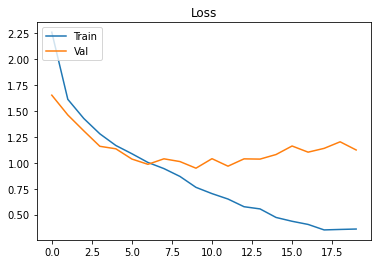

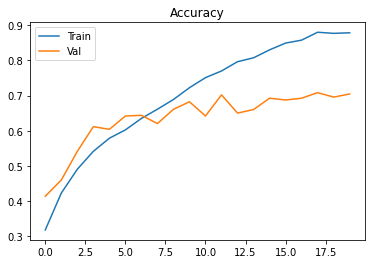

In [14]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [16]:
y_pred=CNNmodel.predict(X_test)

62/62 [==============================] - 4s 57ms/step


In [18]:
conf_matrix = tensorflow.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1))
print(conf_matrix)

tf.Tensor(
[[137   0   9  12   0  14  14   1   2   9]
 [  0 186   2   0   0   9   0   0   0   1]
 [ 14   0  91  25   2  15   3  11   3  34]
 [  2   0   0 132  17   3   2  16  13  13]
 [  3   1   0  21 133   0   4  19  13   4]
 [  1  18   4   4   0 159   0   0   4   8]
 [  8   0   0   2   4   0 173   0   1  10]
 [  3   2   5   7  15   1   0 160   3   2]
 [  4   0   8  27  28   4   0  10 104  13]
 [  7   0   6  43   4  13  12   0   7 106]], shape=(10, 10), dtype=int32)


In [ ]:
input_shape=(20,259)

model_2 = keras.Sequential([
    
    LSTM(256,input_shape=input_shape),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(10, activation='softmax'),
])
print(model_2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               528384    
                                                                 
 dense_24 (Dense)            (None, 1024)              263168    
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_22 (Dropout)        (None, 256)              

In [ ]:
model_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
model_2_history = model_2.fit(X_train, y_train, epochs=30, validation_data= (X_val, y_val))

Epoch 1/30
179/179 [==============================] - 25s 120ms/step - loss: 2.2275 - accuracy: 0.1342 - val_loss: 2.1070 - val_accuracy: 0.2118
Epoch 2/30
179/179 [==============================] - 21s 116ms/step - loss: 2.0865 - accuracy: 0.2089 - val_loss: 2.0423 - val_accuracy: 0.2349
Epoch 3/30
179/179 [==============================] - 20s 114ms/step - loss: 1.9580 - accuracy: 0.2606 - val_loss: 2.0262 - val_accuracy: 0.2419
Epoch 4/30
179/179 [==============================] - 21s 118ms/step - loss: 1.8122 - accuracy: 0.3157 - val_loss: 2.0526 - val_accuracy: 0.2349
Epoch 5/30
179/179 [==============================] - 19s 109ms/step - loss: 1.6732 - accuracy: 0.3650 - val_loss: 2.2194 - val_accuracy: 0.2356
Epoch 6/30
179/179 [==============================] - 19s 108ms/step - loss: 1.5284 - accuracy: 0.4170 - val_loss: 2.2551 - val_accuracy: 0.2468
Epoch 7/30
179/179 [==============================] - 21s 115ms/step - loss: 1.4397 - accuracy: 0.4495 - val_loss: 2.4565 - val_ac

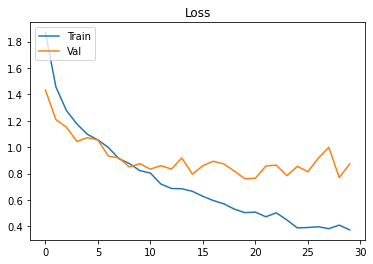

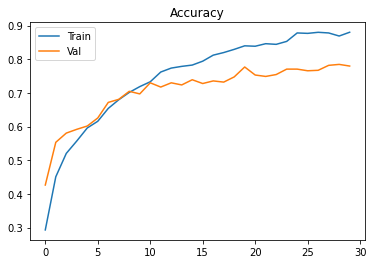

In [ ]:
loss_curve = model_2_history.history["loss"]
acc_curve = model_2_history.history["accuracy"]

loss_val_curve = model_2_history.history["val_loss"]
acc_val_curve = model_2_history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [15]:
y_pred=model_2.predict(X_test)
print('Confusion_matrix: ',tensorflow.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

NameError: ignored

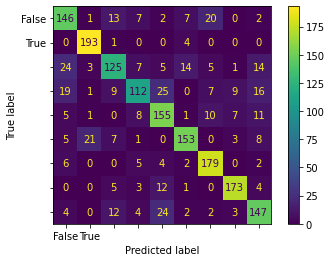

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, np.argmax(y_pred,axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
print(X_test.shape)

(1782, 259, 20)


In [19]:
StrtMin = 1
StrtSec = 0

EndMin = 1
EndSec = 40

# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000

In [26]:
audio = AudioSegment.from_wav("/content/Christina Aguilera, Lil' Kim, Mya, P!nk - Lady Marmalade-RQa7SvVCdZk.wav")
newAudio = audio[StrtTime:EndTime]
newAudio.export('/content/song.wav', format='wav')

for w in range(0,10):
          t1 = 3*(w)*1000
          t2 = 3*(w+1)*1000
          newAudio = AudioSegment.from_wav('/content/song.wav')
          new = newAudio[t1:t2]
          new.export(f'/content/{str(w)}.wav', format='wav')

In [27]:
classe = []

for i in range(0,10):
  y,sr = librosa.load(f'{str(w)}.wav',duration=3)
  data = np.array([librosa.feature.mfcc(y=y,sr=sr, n_fft=1012, hop_length=256, n_mfcc=20)])
  data = tensorflow.expand_dims(data, axis = -1) 
  prediction = CNNmodel.predict(data)
  class_label = np.argmax(prediction)
  print(class_label)
  classe.append(class_label)

moyenne = int(sum(classe)/len(classe))
print(genres_musicaux[moyenne])

1/1 [==============================] - 0s 44ms/step
7
1/1 [==============================] - 0s 30ms/step
7
1/1 [==============================] - 0s 29ms/step
7
1/1 [==============================] - 0s 34ms/step
7
1/1 [==============================] - 0s 31ms/step
7
1/1 [==============================] - 0s 28ms/step
7
1/1 [==============================] - 0s 42ms/step
7
1/1 [==============================] - 0s 37ms/step
7
1/1 [==============================] - 0s 30ms/step
7
1/1 [==============================] - 0s 29ms/step
7
pop
